# Introducción sencilla a Redes Neuronales con Keras

**Autor:** _Tu nombre aquí_  
**Duración sugerida:** 60–90 minutos  
**Nivel:** Principiante



## Objetivos de la clase

- Entender **qué es** una red neuronal y por qué funciona.
- Conocer los conceptos base: **neuronas, pesos, sesgo, activación, pérdida, gradiente, backpropagation** (a nivel intuitivo).
- Aprender el flujo de trabajo en Keras: **definir el modelo → compilar → entrenar → evaluar → predecir**.
- Practicar con un ejemplo **tabular** sencillo.
- Cerrar con un ejemplo **de imágenes** (MNIST) usando una CNN muy pequeña.



## Requisitos y setup

- Python 3.9+
- TensorFlow/Keras 2.10+ (o superior).
- CPU es suficiente (GPU acelera, pero no es necesaria).
- Si usas Google Colab, puedes ejecutar con pocos cambios (las celdas instalarán/mostrarán versiones).

> Nota: Este notebook es **didáctico**. Optimiza la **claridad** sobre el rendimiento.



## Mapa de contenidos

1. **¿Qué es una red neuronal?** (intuición)
2. **El perceptrón**: pesos, sesgo y activación
3. **Función de pérdida y gradiente** (intuición de backprop)
4. **Keras en 5 pasos**: `Sequential`, capas, `compile`, `fit`, `evaluate/predict`
5. **Ejemplo tabular**: clasificación 2D con regularización y _EarlyStopping_
6. **Ejemplo final con imágenes (MNIST)**: CNN mínima y análisis de métricas
7. **Glosario y preguntas de chequeo**



## 1. ¿Qué es una red neuronal? (intuición)

Una red neuronal es una **función paramétrica** $f_\theta(x)$ con parámetros (pesos) $\theta$ que transforma una entrada $x$ en una salida $\\hat{y}$.  
Se compone de **capas** de neuronas. Cada neurona realiza: suma ponderada + **sesgo** + **función de activación**.

- **Pesos ($w$)**: qué tan importante es cada característica de entrada.
- **Sesgo ($b$)**: desplaza la activación (como mover la recta en 2D).
- **Activación**: introduce **no linealidad** (sin ella, la red sería una regresión lineal).
- **Capas ocultas**: permiten aproximar funciones complejas (Teorema de aproximación universal).

**Aprendizaje:** encontramos pesos $\\theta$ que **minimizan** una **función de pérdida** (p. ej., entropía cruzada).  
Se usa **descenso por gradiente** y **backpropagation** para ajustar los pesos.



## 2. El perceptrón (capa densa)

Una neurona:
$$ z = w^\top x + b,\qquad a = \phi(z) $$

Donde $\\phi$ es la **activación**. Algunas activaciones frecuentes:

- **ReLU**: $\\text{ReLU}(z) = \max(0, z)$ → rápida y estable.
- **Sigmoide**: output entre (0,1), útil para **binario**.
- **tanh**: output entre (-1,1), centrada.

> En Keras, una capa densa es `tf.keras.layers.Dense(units, activation=...)`.



## 3. Pérdida y gradiente (intuición de backprop)

- **Pérdida** ($\mathcal{L}$): mide qué tan mal predice el modelo.
  - Regresión: MSE.
  - Clasificación binaria: entropía cruzada binaria.
  - Multiclase: entropía cruzada categórica.
- **Gradiente**: indica en qué dirección cambiar $\\theta$ para reducir $\mathcal{L}$.
- **Backpropagation**: aplica la **regla de la cadena** para propagar gradientes desde la salida hacia las capas anteriores.
- **Optimizadores** (SGD, Adam): variantes del descenso por gradiente para actualizar pesos.

En Keras, esto se **automatiza** al llamar `model.compile(optimizer=..., loss=..., metrics=[...])` y luego `model.fit(...)`.



## 4. Keras en 5 pasos

1) **Definir el modelo** (p. ej. `Sequential`) y las **capas**.  
2) **Compilar**: fijar `optimizer`, `loss`, `metrics`.  
3) **Entrenar**: `fit(X_train, y_train, epochs, batch_size, validation_data=...)`.  
4) **Evaluar**: `evaluate(X_test, y_test)` para métricas en datos no vistos.  
5) **Predecir**: `predict(nuevos_datos)`.

> Buenas prácticas: usar `EarlyStopping`, normalizar/estandarizar entradas, y separar `train/valid/test`.


In [1]:

# 0) Setup: versiones y semillas
import numpy as np, tensorflow as tf, os, random
print('TensorFlow:', tf.__version__)

# Semillas para reproducibilidad (hasta donde es posible)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


TensorFlow: 2.17.1



## 5. Ejemplo tabular: clasificación 2D

**Meta:** clasificar puntos 2D de dos clases generadas artificialmente.  
Trabajaremos con un modelo **`Sequential`** pequeño (2-3 capas densas) y veremos:

- Overfitting vs generalización.
- Regularización con **Dropout** y **L2**.
- Uso de **EarlyStopping** con validación.


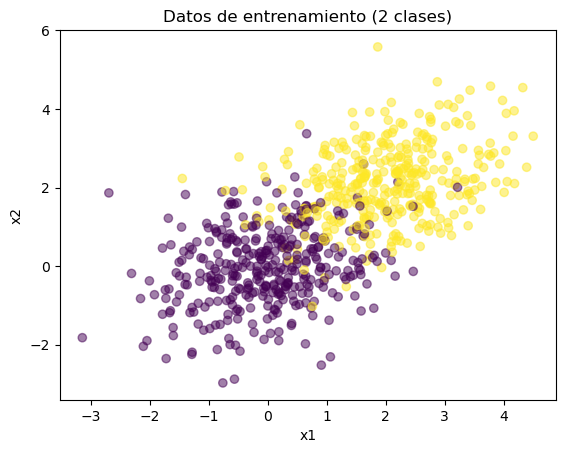

In [2]:

# Generamos un dataset sencillo (dos nubes de puntos en 2D)
import numpy as np
import matplotlib.pyplot as plt

n_per_class = 600
mean0, mean1 = np.array([0, 0]), np.array([2.0, 2.0])
cov = np.array([[1.0, 0.3],
                [0.3, 1.0]])

X0 = np.random.multivariate_normal(mean0, cov, size=n_per_class)
X1 = np.random.multivariate_normal(mean1, cov, size=n_per_class)

X = np.vstack([X0, X1]).astype('float32')
y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)]).astype('float32')

# Split train/valid/test 60/20/20
n = len(X)
idx = np.arange(n)
np.random.shuffle(idx)
X, y = X[idx], y[idx]

n_train = int(0.6*n)
n_valid = int(0.2*n)

X_train, y_train = X[:n_train], y[:n_train]
X_valid, y_valid = X[n_train:n_train+n_valid], y[n_train:n_train+n_valid]
X_test,  y_test  = X[n_train+n_valid:], y[n_train+n_valid:]

# Visualización rápida (se dibuja en runtime)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, alpha=0.5)
plt.title('Datos de entrenamiento (2 clases)')
plt.xlabel('x1'); plt.ylabel('x2')
plt.show()

# Estandarización simple (media 0, var 1) con estadísticas de TRAIN
mu = X_train.mean(axis=0, keepdims=True)
sigma = X_train.std(axis=0, keepdims=True) + 1e-7
X_train_n = (X_train - mu) / sigma
X_valid_n = (X_valid - mu) / sigma
X_test_n  = (X_test  - mu) / sigma


In [3]:

# Definimos un MLP pequeño en Keras para binario
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.1),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dense(1, activation='sigmoid')  # salida binaria
])

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

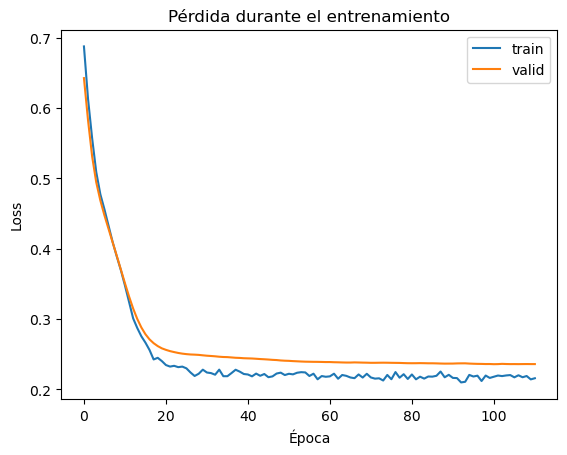

>> Test loss: 0.2478 | Test acc: 0.9000


In [4]:

# Entrenamiento con EarlyStopping para evitar sobreajuste
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist = model.fit(X_train_n, y_train,
                 validation_data=(X_valid_n, y_valid),
                 epochs=200,
                 batch_size=32,
                 callbacks=[es],
                 verbose=0)

# Curvas de entrenamiento (se dibujan al ejecutar)
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='valid')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend(); plt.show()

# Evaluación en test
test_loss, test_acc = model.evaluate(X_test_n, y_test, verbose=0)
print(f'>> Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')



**Ideas para discutir**

- ¿Qué pasa si quitamos `Dropout` y L2? ¿Sube el overfitting?
- Cambia el número de neuronas/capas y comenta el efecto.
- Prueba otros optimizadores (`sgd`, `rmsprop`) y tasas de aprendizaje (`learning_rate`).



## 6. Ejemplo final con imágenes (MNIST)

Usaremos **MNIST** (28×28 en escala de grises). Flujo:

1. Cargar y normalizar imágenes.
2. Definir una **CNN mínima** (Conv2D → ReLU → MaxPool → Flatten → Dense).
3. Compilar y entrenar con validación.
4. Evaluar en test y hacer predicciones de ejemplo.

> Objetivo didáctico: entender **cómo** encaja Keras en el problema, no optimizar al máximo.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1) Datos
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalización a [0,1] y reshape a (H,W,1)
x_train = (x_train.astype('float32') / 255.0)[..., None]
x_test  = (x_test.astype('float32') / 255.0)[..., None]

# Separar un pequeño validation set
x_valid, y_valid = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

print('x_train:', x_train.shape, 'x_valid:', x_valid.shape, 'x_test:', x_test.shape)

x_train: (50000, 28, 28, 1) x_valid: (10000, 28, 28, 1) x_test: (10000, 28, 28, 1)


In [7]:
# 2) Modelo CNN mínima
cnn = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(16, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 clases
])

cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,714 (221.54 KB)

 Trainable params: 56,714 (221.54 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 3) Compile
cnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [9]:
# 4) Train
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist_cnn = cnn.fit(x_train, y_train,
                   validation_data=(x_valid, y_valid),
                   epochs=10,
                   batch_size=64,
                   verbose=1,
                   callbacks=[es])

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9301 - loss: 0.2371 - val_accuracy: 0.9788 - val_loss: 0.0778
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9798 - loss: 0.0677 - val_accuracy: 0.9822 - val_loss: 0.0626
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9853 - loss: 0.0480 - val_accuracy: 0.9823 - val_loss: 0.0621
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9887 - loss: 0.0367 - val_accuracy: 0.9807 - val_loss: 0.0676
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9912 - loss: 0.0287 - val_accuracy: 0.9805 - val_loss: 0.0702
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9933 - loss: 0.0228 - val_accuracy: 0.9825 - val_loss: 0.0652
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9943 - loss: 0.0183 - val_accuracy: 0.9821 - val_loss: 0.0732
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9953 - loss: 0.0155 - val_accuracy: 0.

In [10]:
# 5) Evaluate
test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=0)
print(f'>> MNIST Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

>> MNIST Test loss: 0.0461 | Test acc: 0.9881


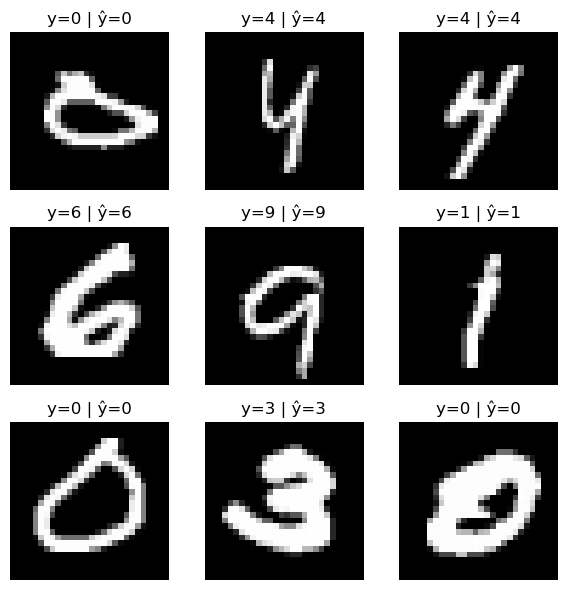

In [11]:
# 6) Predicción de ejemplo
import numpy as np, matplotlib.pyplot as plt
idx = np.random.randint(0, len(x_test), size=9)
imgs, labels = x_test[idx], y_test[idx]
pred = cnn.predict(imgs, verbose=0).argmax(axis=1)

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f'y={labels[i]} | ŷ={pred[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()



## 7. Glosario y preguntas de chequeo

**Glosario breve**  
- **Capa densa**: cada neurona está conectada con todas las entradas de la capa previa.  
- **Activación**: función no lineal aplicada a la salida de la neurona (ReLU, sigmoide, tanh).  
- **Época**: una pasada completa por el conjunto de entrenamiento.  
- **Batch**: número de ejemplos usados para una actualización de pesos.  
- **Pérdida**: función objetivo a minimizar (p. ej., entropía cruzada).  
- **Regularización**: técnicas para reducir overfitting (Dropout, L2, early stopping).  
- **Callback**: hook durante el entrenamiento (p. ej., EarlyStopping, ModelCheckpoint).

**Preguntas rápidas**  
1. ¿Por qué necesitamos funciones de activación no lineales?  
2. ¿Qué mide la función de pérdida?  
3. Diferencia entre `train`, `validation` y `test`.  
4. ¿Qué hace `EarlyStopping` y cuándo es útil?  
5. ¿Por qué normalizamos/estandarizamos las entradas?
